In [2]:
# standard libraries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import warnings
warnings.simplefilter('ignore')
import gc

# keras libraries
import tensorflow
from tensorflow import keras
from keras import models
from keras import layers
from keras import metrics
from keras.metrics import Precision
from tqdm.keras import TqdmCallback
from keras.backend import clear_session

# sklearn libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import mutual_info_classif
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import RobustScaler,MinMaxScaler,StandardScaler

# visualisation
import seaborn as sns
import matplotlib.pyplot as plt

ModuleNotFoundError: No module named 'tqdm'

### Load Data

In [2]:
# load data
file = '../input/pumpkin-seeds-dataset/Pumpkin_Seeds_Dataset/Pumpkin_Seeds_Dataset.xlsx'
df = pd.read_excel(file, sheet_name='Pumpkin_Seeds_Dataset',engine='openpyxl')

# drop NULLs
df.dropna(inplace=True)

# encoding the target
le = LabelEncoder()
df.Class = le.fit_transform(df['Class']) 

# print details
print(f"There are {df.shape[0]} records with {df.Class.nunique()} classes")
print(f"Classes are: {', '.join(x for x in list(le.classes_))}")

There are 2500 records with 2 classes
Classes are: Çerçevelik, Ürgüp Sivrisi


### Feature Engineering & Selection

In [3]:
# define features and target
X = df.drop('Class',axis=1)
y = df[['Class']]

# converting all the features (which are not) to float 
int_cols = X.select_dtypes(include=np.int_).columns.tolist()
for c in int_cols:
    X[c] = X[c].astype('float')
    
# split training & test data [80-20 split]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=np.random.randint(100))

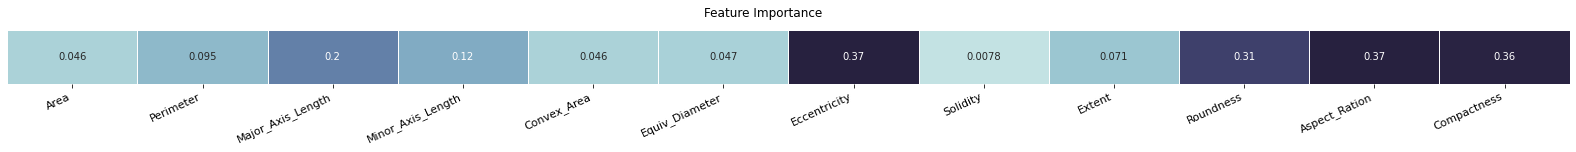

In [4]:
# Feature selection
mutual_information = mutual_info_classif(X_train, y_train, n_neighbors=5, copy = True)

plt.subplots(1, figsize=(28, 1))
sns.color_palette("Set2")
sns.heatmap(mutual_information[:, np.newaxis].T, cmap=sns.color_palette("ch:start=.2,rot=-.3", as_cmap=True), cbar=False, linewidths=1, annot=True, annot_kws={"size": 10})
plt.yticks([], [])
plt.gca().set_xticklabels(X.columns, rotation=25, ha='right', fontsize=11)
plt.suptitle("Feature Importance", fontsize=12, y=1.2)
plt.gcf().subplots_adjust(wspace=0.4)

**As observed from the above map, the following features have more effect on the target than others:**

* Eccentricity
* Roundness
* Aspect_Ration
* Compactness
* Major_Axis_Length

In [5]:
# new feature list
imp_cols = ['Eccentricity', 'Roundness', 'Aspect_Ration', 'Compactness', 'Major_Axis_Length']
X_new = X[imp_cols]

# scaling the features
rs = RobustScaler()
X_scaled = rs.fit_transform(X_new)

# split training & test data [80-20 split] -- again
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.20, random_state=np.random.randint(100))

# record stats
print(f"Training Records = {X_train.shape[0]} ; Validation Record {X_test.shape[0]} ")

Training Records = 2000 ; Validation Record 500 


### Build & Fit Model

In [6]:
# define model params
input_shape = X_train.shape[1]                                                         
output_shape = y_train.shape[1]                                                           
nodes = np.ceil(2 * input_shape / 3 + output_shape).astype(int)                         
batch_size = np.ceil(len(X_train) / 128).astype(int)                                     

# build model
model = models.Sequential()
# input layer
model.add(layers.Dense(
                        batch_size
                       ,input_shape=(input_shape,)
                       ,name='input_layer'
                       ,activation='selu'))
# hidden layer
model.add(layers.Dense(
                        nodes
                        ,name='hidden_nides'
                       ,activation='selu'))
# dropout layer
model.add(layers.Dropout(0.5))

# output layer
model.add(layers.Dense(
                        output_shape
                        ,name='output_layer'
                       ,activation='sigmoid'))

# compile model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# summmary
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (Dense)          (None, 16)                96        
_________________________________________________________________
hidden_nides (Dense)         (None, 5)                 85        
_________________________________________________________________
dropout (Dropout)            (None, 5)                 0         
_________________________________________________________________
output_layer (Dense)         (None, 1)                 6         
Total params: 187
Trainable params: 187
Non-trainable params: 0
_________________________________________________________________


2022-10-28 01:53:41.929046: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [7]:
# model fit params
epoch = 200

# garbage collect, incase we're re-running the model to get the best fit
gc.collect()
    
# reset model , incase we're re-running the model to get the best fit
clear_session()

# fit the keras model on the dataset
hist = model.fit(X_train
                  ,y_train
                  ,epochs = epoch
                  ,batch_size=batch_size
                  ,shuffle=True
                  ,validation_data=(X_test, y_test)
                  ,verbose=0
                  ,callbacks=[TqdmCallback(verbose=0)]
          )

# save model
#model.save('pumpkinSeedClassification')

0epoch [00:00, ?epoch/s]

2022-10-28 01:53:42.488368: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


In [8]:
acc = '{:.2%}'.format(hist.history['accuracy'][-1])
print(f"The model has achieved an accuracy of {acc} with {epoch} epochs")

The model has achieved an accuracy of 87.30% with 200 epochs


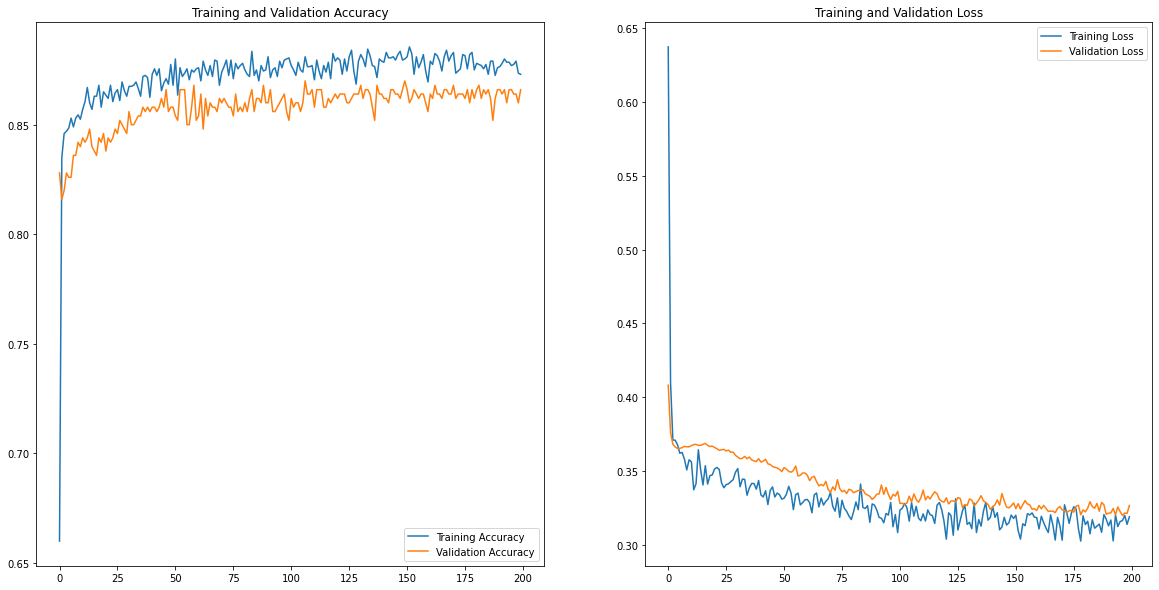

In [9]:
# visualize training results
acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']

loss = hist.history['loss']
val_loss = hist.history['val_loss']

epochs_range = range(epoch)

plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

**We can observe that, our model has achieved a good validation accuracy infact it is higher than the training accuracy**

### Prediction & Evaluation

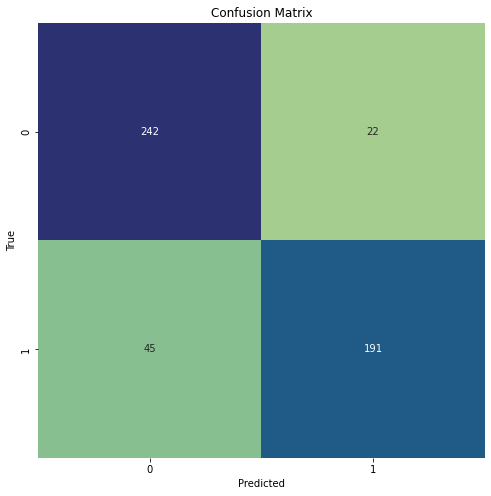

In [10]:
# Predictions 
y_pred = model.predict(X_test)
y_pred_class = [round(x[0]) for x in y_pred]
y_test_class = y_test.reset_index(drop=True)

# confusion matrix
cfm = confusion_matrix(y_test_class, y_pred_class)

# visualise confusion matrix
plt.figure(figsize=(8,8))
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in cfm.flatten()]
labels = [f"{v1}\n{v2}" for v1, v2 in zip(group_names,group_counts)]
sns.heatmap(cfm, annot=True, cmap='crest', cbar=False, fmt='g')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

**There are a total of 59 records for which the model has done a 'False' predictions which is approx 12% of the total Validation dataset.**

In [11]:
# classification report
class_names = []
for i in y['Class'].unique():
    class_names.append(le.inverse_transform([i])[0])

print(classification_report(y_test_class, y_pred_class, target_names=class_names))

               precision    recall  f1-score   support

   Çerçevelik       0.84      0.92      0.88       264
Ürgüp Sivrisi       0.90      0.81      0.85       236

     accuracy                           0.87       500
    macro avg       0.87      0.86      0.86       500
 weighted avg       0.87      0.87      0.87       500

